In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline           
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
import seaborn as sn
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm 
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_absolute_error


In [106]:
Datos=pd.read_csv("Historical Product Demand.csv")
Datos.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.
The information contained in the dataset was encoded to protect the company's identity.

Date variable must be formated as datetime for time series analysis.

In [107]:
Datos_datetime=Datos
Datos_datetime["Date"]=pd.to_datetime(Datos["Date"],format="%Y/%m/%d")
Datos_datetime.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

Checking for missing values

In [108]:
print(Datos_datetime.isnull().sum())
print ('Null to Dataset Ratio for "Dates" Column '': ',Datos_datetime.isnull().sum()[3]/Datos_datetime.shape[0]*100)

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio for "Dates" Column :  1.0718355863910547


The null data will be removed due to it being around 1% of the data.

In [109]:
Datos_datetime.dropna(axis=0, inplace=True)
Datos_datetime.reset_index(drop=True)
Datos_datetime.sort_values('Date')[1:50]
Datos_datetime['Order_Demand']=Datos_datetime['Order_Demand'].str.replace('(',"")
Datos_datetime['Order_Demand']=Datos_datetime['Order_Demand'].str.replace(')',"")
Datos_clean=Datos_datetime
Datos_clean.head()

<ipython-input-109-2f038d1d97d6>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  Datos_datetime['Order_Demand']=Datos_datetime['Order_Demand'].str.replace('(',"")
<ipython-input-109-2f038d1d97d6>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  Datos_datetime['Order_Demand']=Datos_datetime['Order_Demand'].str.replace(')',"")


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [110]:
Datos_clean['Order_Demand'] = Datos_clean['Order_Demand'].astype('int64')
Datos_clean.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

In [111]:
print(Datos_clean.isnull().sum())
print ('Null to Dataset Ratio for "Dates" Column '': ',Datos_clean.isnull().sum()[3]/Datos_clean.shape[0]*100)

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64
Null to Dataset Ratio for "Dates" Column :  0.0


In [112]:
Datos_clean['Date'].min() , Datos_clean['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

The time series goes from January 2011 to January 2017.

In [113]:
Datos_clean['Warehouse'].value_counts().sort_values(ascending=False)
Datos_WH=Datos_clean.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
Datos_WH

,Order_Demand
Warehouse,
Whse_J,3363200396
Whse_S,1038024700
Whse_C,585071404
Whse_A,147877431


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


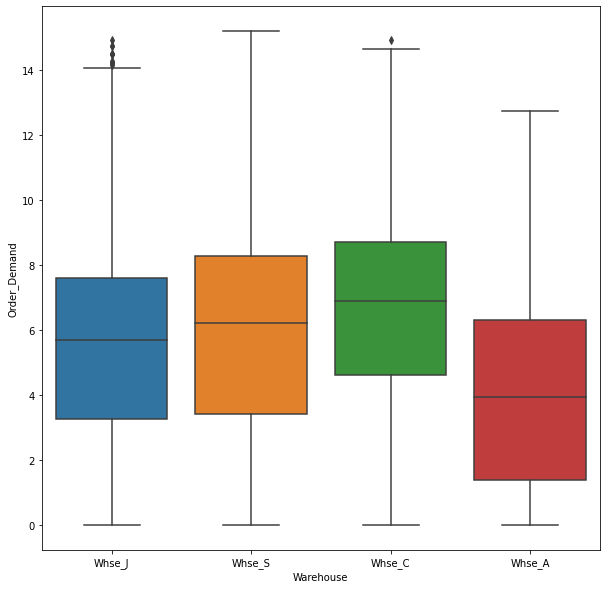

In [114]:
rcParams['figure.figsize']=10,10 
logDataWH=sn.boxplot(Datos_clean['Warehouse'],np.log1p(Datos_clean['Order_Demand'])) 
del  logDataWH

Product Code exploration

In [115]:
print(len(Datos_clean['Product_Code'].value_counts()))

2160


There are 2160 different products

Product Category exploration

Product Categories:
33


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Product_Category', ylabel='count'>

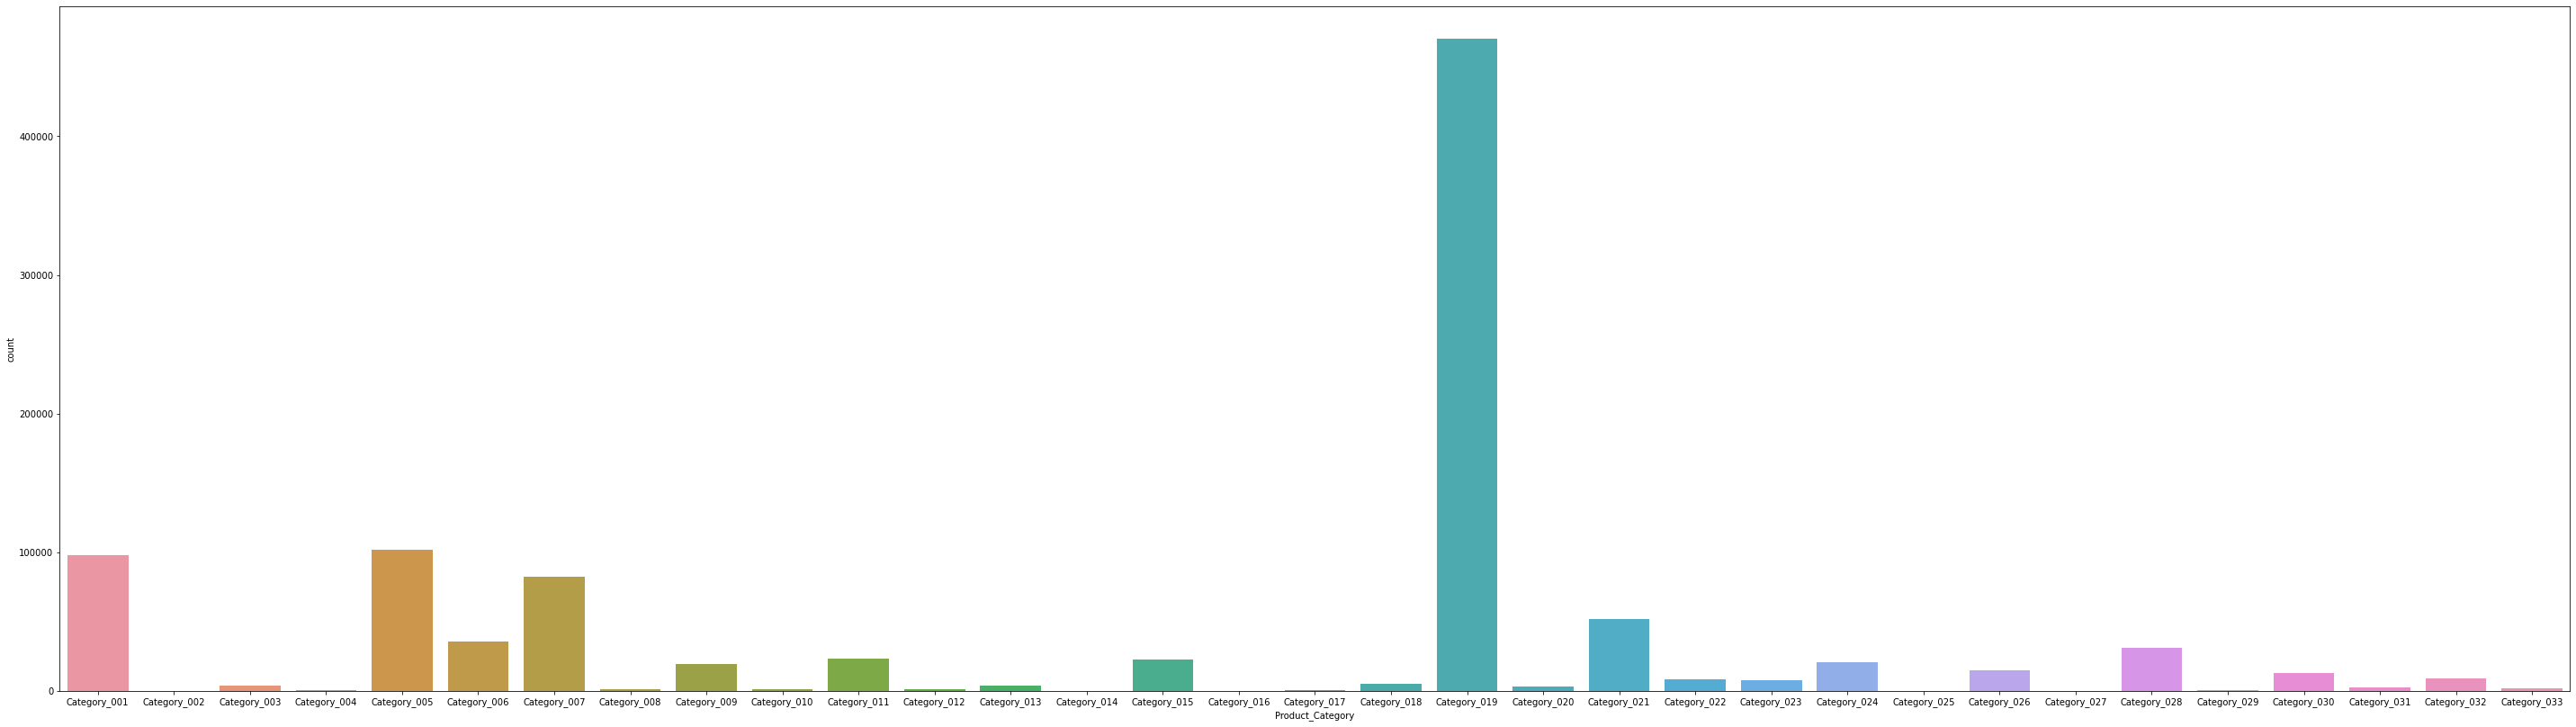

In [116]:
print("Product Categories:")
print(len(Datos_clean['Product_Category'].value_counts()))
rcParams['figure.figsize']=50,14
sn.countplot(Datos_clean['Product_Category'].sort_values(ascending=True))

There are 33 existing product categories.

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


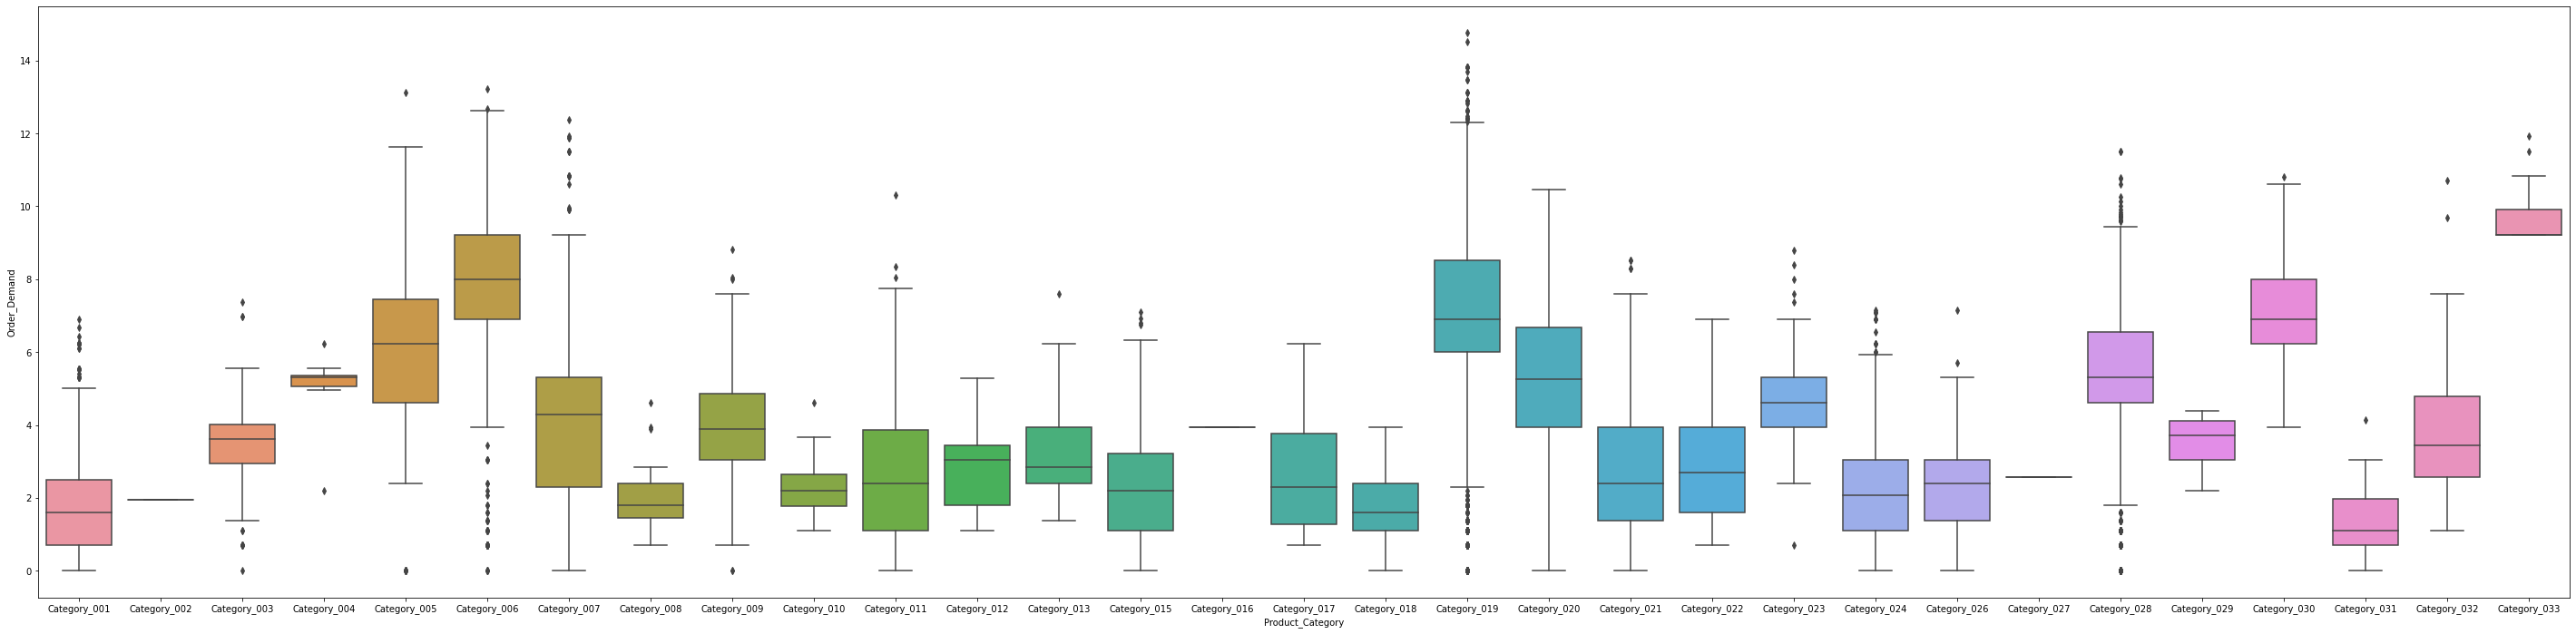

In [117]:
rcParams['figure.figsize'] = 50,12
df_temp = Datos_clean.sample(n=20000).reset_index()
fig5 = sn.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5

Due to the existance of too many distinct products and the differences in the product category means, the demand forecasting will be done according to product categories.

In [118]:
Datos_PC=Datos_clean.groupby('Product_Category').count()
Datos_PC=Datos_PC.rename(columns={"Warehouse":"Frequency"})
Datos_PC.drop(columns={"Product_Code","Date","Order_Demand"})
DatosPC_sorted=Datos_PC["Frequency"].sort_values(ascending=False)
DatosPC_sorted

Product_Category
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: Frequency, dtype: int64

The categories of choice for the predictions done in this study were 019, 005 and 001. Since these three are the most frequent categories present on this dataset.

Here we separate the dataset in 3 depending on the product category.

In [119]:
Datos_Cat019=Datos_clean[Datos_clean["Product_Category"]=="Category_019"]
Datos_Cat019=Datos_Cat019[["Date", "Order_Demand"]]
Datos_Cat001=Datos_clean[Datos_clean["Product_Category"]=="Category_001"]
Datos_Cat001=Datos_Cat001[["Date", "Order_Demand"]]
Datos_Cat005=Datos_clean[Datos_clean["Product_Category"]=="Category_005"]
Datos_Cat005=Datos_Cat005[["Date", "Order_Demand"]]

In [120]:
TS_019=Datos_Cat019.set_index("Date")
TS_005=Datos_Cat005.set_index("Date")
TS_001=Datos_Cat001.set_index("Date")

In [121]:
TS_019 = TS_019['Order_Demand'].resample('MS').mean()
TS_019 = TS_019.fillna(TS_019.bfill())
TS_005 = TS_005['Order_Demand'].resample('MS').mean()
TS_005 = TS_005.fillna(TS_005.bfill())
TS_001 = TS_001['Order_Demand'].resample('MS').mean()
TS_001 = TS_001.fillna(TS_001.bfill())

Here we separate the time series in training and testing. Having 70% of the data for training and the 30% for testing.

In [122]:
lim_019=round(len(TS_019)*0.7)
TS_019_Training=TS_019[1:lim_019]
TS_019_Testing=TS_019[lim_019+1:]

lim_005=round(len(TS_005)*0.7)
TS_005_Training=TS_005[1:lim_005]
TS_005_Testing=TS_005[lim_005+1:]

lim_001=round(len(TS_005)*0.7)
TS_001_Training=TS_001[1:lim_001]
TS_001_Testing=TS_001[lim_001+1:]


In [123]:
#Defining function for Time series decomposition
def decompose(data):
    rcParams['figure.figsize'] = 20, 10
    decomposition = sm.tsa.seasonal_decompose(data, model='additive')
    fig = decomposition.plot()
    return plt.show()

Category 019 Time Series Decomposition

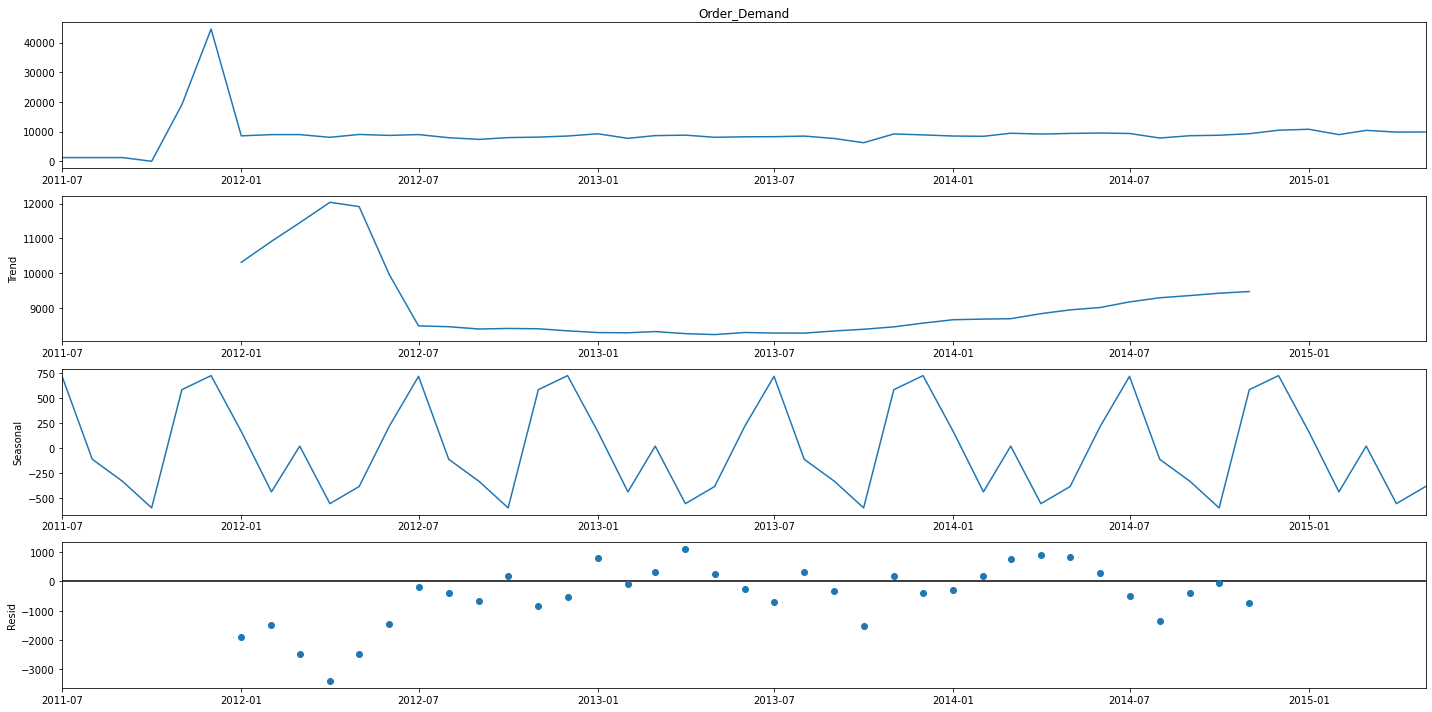

In [124]:
decompose(TS_019_Training)

Category 005 Time Series Decomposition

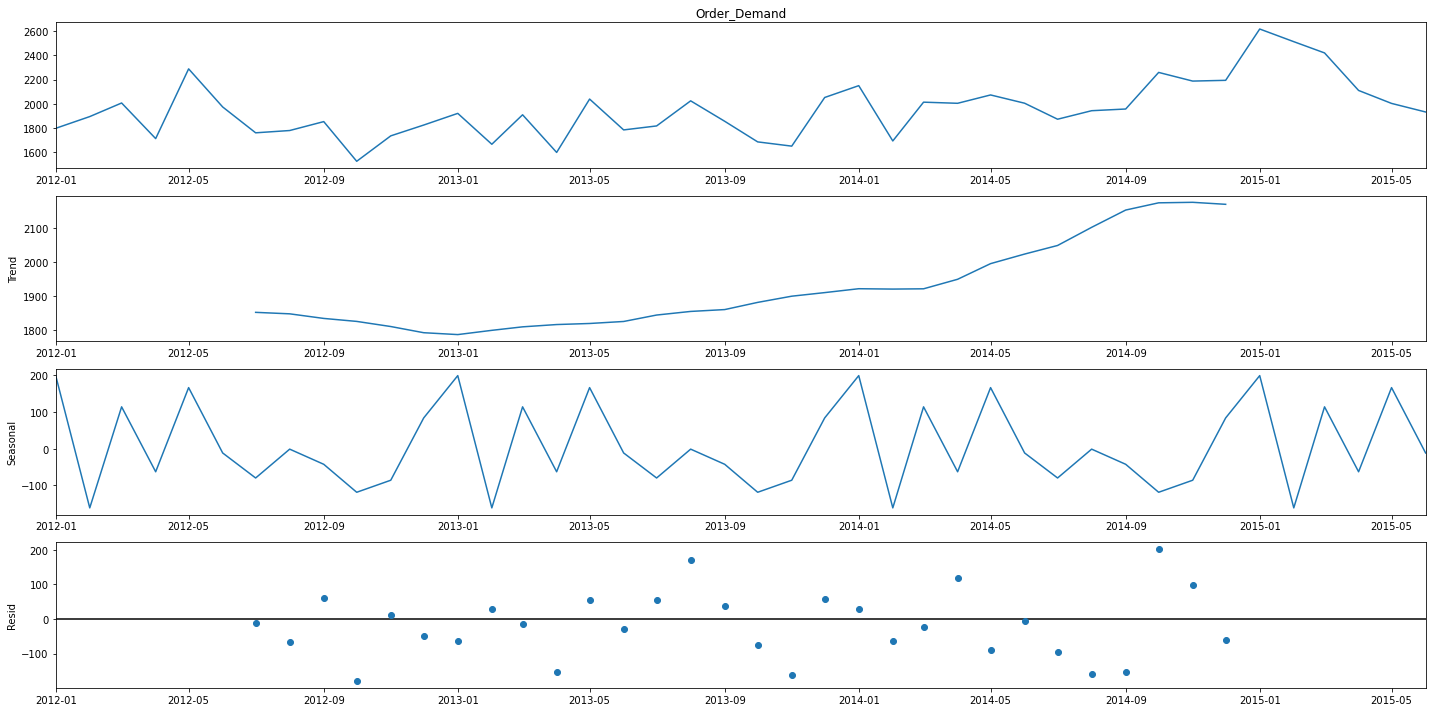

In [125]:
decompose(TS_005_Training)

Category 001 Time Series Decomposition

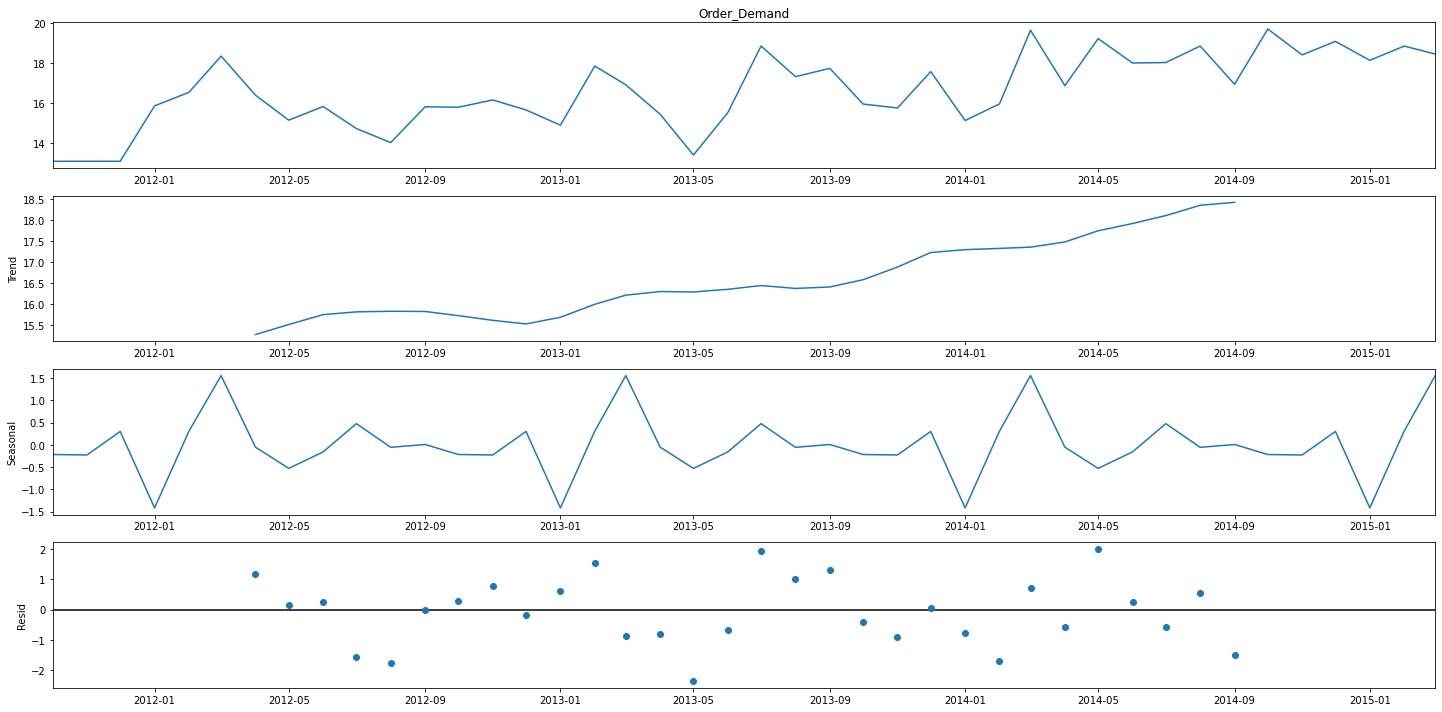

In [126]:
decompose(TS_001_Training)

Dickey Fuller stationarity test

In [127]:
#Defining function for Dickey Fuller test
def DF_test(data):
    print("Results of Dickey Fuller Test:")
    dftest=adfuller(data,autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

In [128]:
DF_test(TS_019_Training)

Category 019 Time Series
Results of Dickey Fuller Test:
Test Statistic                 -5.103645
p-value                         0.000014
#Lags Used                      0.000000
Number of Observations Used    46.000000
dtype: float64


In [129]:
DF_test(TS_005_Training)

Category 019 Time Series
Results of Dickey Fuller Test:
Test Statistic                 -5.103645
p-value                         0.000014
#Lags Used                      0.000000
Number of Observations Used    46.000000
dtype: float64


In [130]:
DF_test(TS_001_Training)

Category 019 Time Series
Results of Dickey Fuller Test:
Test Statistic                 -5.103645
p-value                         0.000014
#Lags Used                      0.000000
Number of Observations Used    46.000000
dtype: float64


ARIMA models

Auto-ARIMA

In [131]:
#Defining function for Auto Arima modeling    
def AutoArima(data):
    return auto_arima(data, start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          start_P=0, seasonal=False,
                          d=None, D=1, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

In [132]:
model_019_autoarima=AutoArima(TS_019_Training)
model_019_autoarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1008.947, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=966.570, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=987.953, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=968.051, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=952.533, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=954.272, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=951.576, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=953.690, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=953.953, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=952.454, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=955.758, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.287 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -471.788
Date:                Mon, 03 Jan 2022   AIC                            951.576
Time:                        20:58:47   BIC                            958.977
Sample:                             0   HQIC                           954.361
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8740.3807   1476.826      5.918      0.000    5845.855    1.16e+04
ar.L1          0.3240      0.076      4.253      0.000       0.175       0.473
ar.L2         -0.2713      0.069     -3.945      0.000      -0.406      -0.137
sigma2      2.986e+07      0.379   7.88e+07      0.000    2.99e+07    2.99e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               587.89
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             3.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.54e+22. Standard errors may be unstable.
"""

In [133]:
model_005_autoarima=AutoArima(TS_005_Training)
model_005_autoarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=567.831, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=562.336, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=558.686, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=565.839, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=559.401, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=557.028, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=558.318, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=558.509, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=560.359, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=559.986, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.494 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -276.514
Date:                Mon, 03 Jan 2022   AIC                            557.028
Time:                        20:58:48   BIC                            560.455
Sample:                             0   HQIC                           558.276
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6336      0.139     -4.550      0.000      -0.907      -0.361
sigma2      4.137e+04   1.06e+04      3.898      0.000    2.06e+04    6.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.78   Prob(JB):                         0.62
Heteroskedasticity (H):               1.19   Skew:                             0.22
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
model_001_autoarima=AutoArima(TS_001_Training)
model_001_autoarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=162.075, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=158.476, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=160.328, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=158.631, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=157.029, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=157.461, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=153.612, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=153.240, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=153.710, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.446 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -74.620
Date:                Mon, 03 Jan 2022   AIC                            153.240
Time:                        20:58:48   BIC                            156.667
Sample:                             0   HQIC                           154.488
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6677      0.142     -4.707      0.000      -0.946      -0.390
sigma2         2.1984      0.446      4.927      0.000       1.324       3.073
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.62   Prob(JB):                         0.44
Heteroskedasticity (H):               0.78   Skew:                             0.49
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA Models Visualization

Text(0.5, 1.0, 'Modelo ARMA Cat 019')

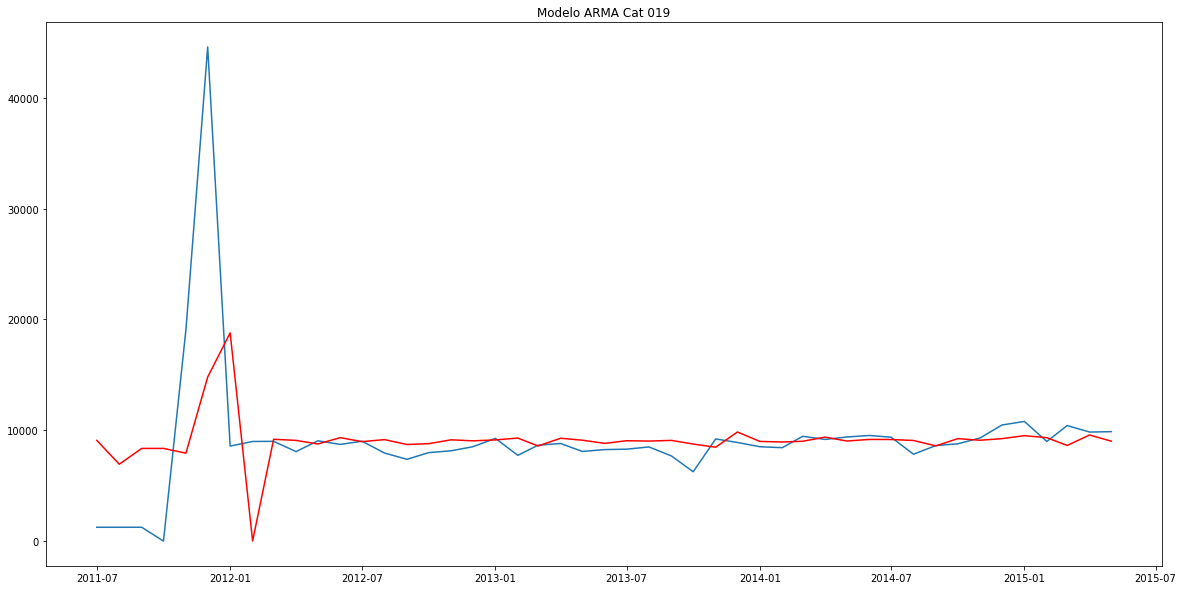

In [135]:
Model_019_arima=ARIMA(TS_019_Training,order=model_019_autoarima.order)
Results_M_019=Model_019_arima.fit()
plt.plot(TS_019_Training)
plt.plot(Results_M_019.fittedvalues, color="red")
plt.title("Modelo ARMA Cat 019")

Text(0.5, 1.0, 'Modelo ARMA Cat 005')

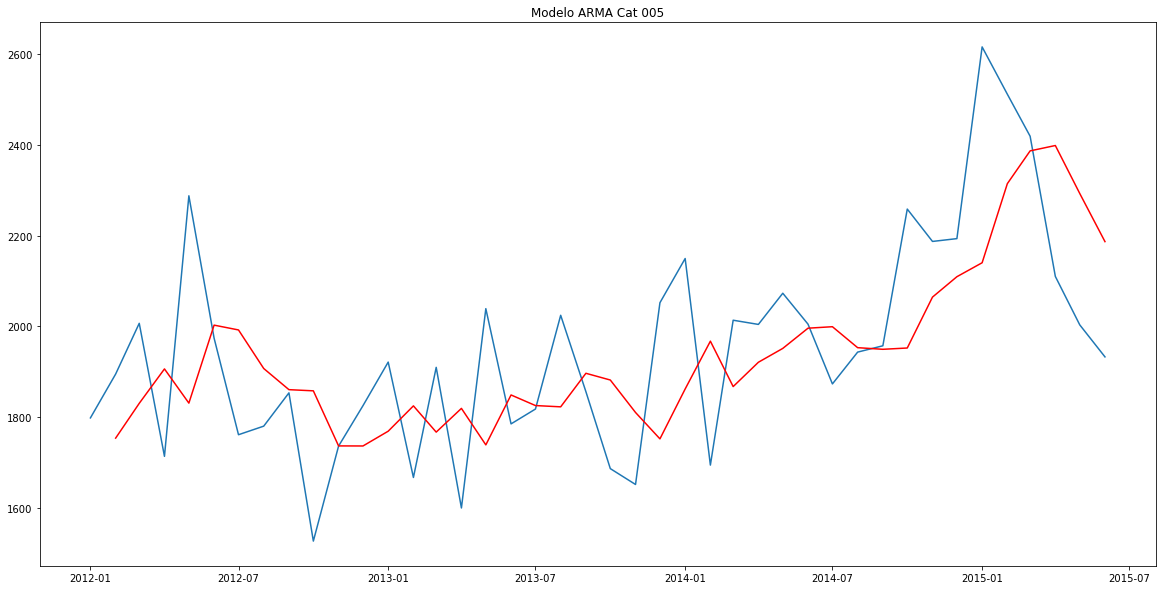

In [136]:
Model_005_arima=ARIMA(TS_005_Training,order=model_005_autoarima.order)
Results_M_005=Model_005_arima.fit()
plt.plot(TS_005_Training)
plt.plot(Results_M_005.fittedvalues[1:], color="red")
plt.title("Modelo ARMA Cat 005")

Text(0.5, 1.0, 'Modelo ARMA Cat 001')

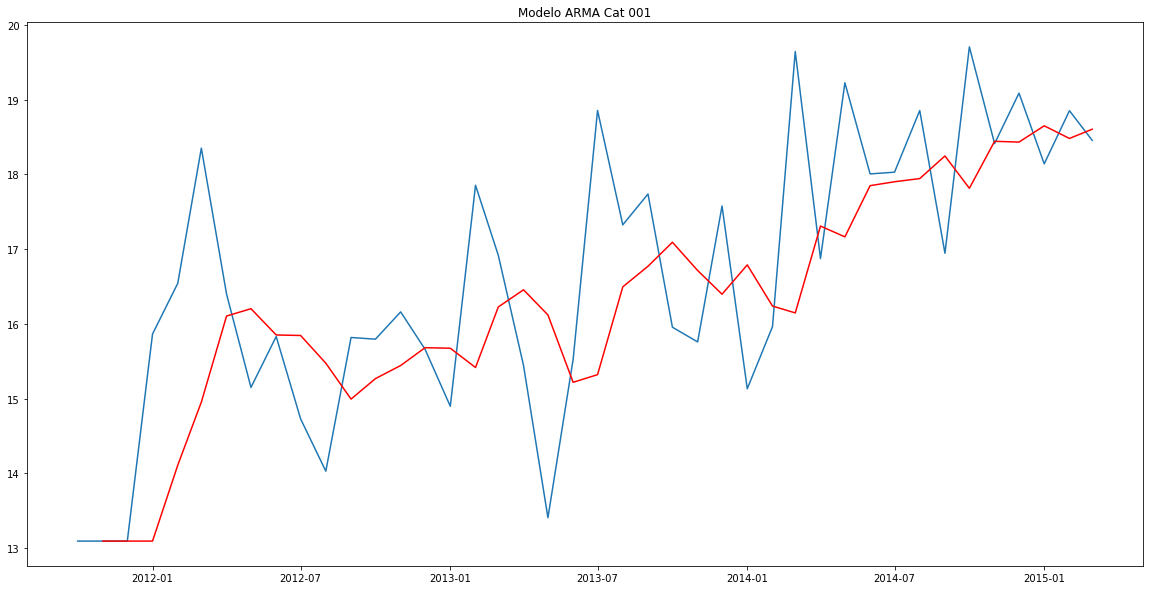

In [137]:
Model_001_arima=ARIMA(TS_001_Training,order=model_001_autoarima.order)
Results_M_001=Model_001_arima.fit()
plt.plot(TS_001_Training)
plt.plot(Results_M_001.fittedvalues[1:], color="red")
plt.title("Modelo ARMA Cat 001")

ARIMA Models Forecats

In [138]:
Forecast_Arima_019=model_019_autoarima.predict(n_periods=len(TS_019_Testing))
Forecast_Arima_019

array([9270.70376907, 9064.62046713, 9162.26193739, 9249.81140092,
       9251.68806736, 9228.54331208, 9220.5348598 , 9224.21932966,
       9227.58591452, 9227.67712152, 9226.79329438, 9226.48217405,
       9226.62115466, 9226.75059605, 9226.75483081, 9226.72108452,
       9226.70900122, 9226.71424164, 9226.71921792])

In [139]:
Forecast_Arima_005=model_005_autoarima.predict(n_periods=len(TS_005_Testing))
Forecast_Arima_005

array([2093.84539898, 2093.84539898, 2093.84539898, 2093.84539898,
       2093.84539898, 2093.84539898, 2093.84539898, 2093.84539898,
       2093.84539898, 2093.84539898, 2093.84539898, 2093.84539898,
       2093.84539898, 2093.84539898, 2093.84539898, 2093.84539898,
       2093.84539898, 2093.84539898])

In [140]:
Forecast_Arima_001=model_001_autoarima.predict(n_periods=len(TS_001_Testing))
Forecast_Arima_001

array([18.55354889, 18.55354889, 18.55354889, 18.55354889, 18.55354889,
       18.55354889, 18.55354889, 18.55354889, 18.55354889, 18.55354889,
       18.55354889, 18.55354889, 18.55354889, 18.55354889, 18.55354889,
       18.55354889, 18.55354889, 18.55354889, 18.55354889, 18.55354889,
       18.55354889])

Error metrics for ARIMA models

In [141]:
MAE_ARIMA_019=mean_absolute_error(Forecast_Arima_019,TS_019_Testing)
MAE_ARIMA_005=mean_absolute_error(Forecast_Arima_005,TS_005_Testing)
MAE_ARIMA_001=mean_absolute_error(Forecast_Arima_001,TS_001_Testing)
print("MAE ARIMA Model Category 019: ",MAE_ARIMA_019)
print("MAE ARIMA Model Category 005: ",MAE_ARIMA_005)
print("MAE ARIMA Model Category 001: ",MAE_ARIMA_001)

MAE ARIMA Model Category 019:  635.6685190444092
MAE ARIMA Model Category 005:  224.92575675655718
MAE ARIMA Model Category 001:  2.076196988321565


XGBoost Models

In [181]:
#Defining function to transform Time Series object into DataFrame
def TS_to_dataframe(time_series):
    df=pd.DataFrame(time_series)
    df.reset_index(inplace=True)
    return df


In [185]:
TS_019_Training_df=TS_to_dataframe(TS_019_Training)
TS_005_Training_df=TS_to_dataframe(TS_005_Training)
TS_001_Training_df=TS_to_dataframe(TS_001_Training)

TS_019_Testing_df=TS_to_dataframe(TS_019_Testing)
TS_005_Testing_df=TS_to_dataframe(TS_005_Testing)
TS_001_Testing_df=TS_to_dataframe(TS_001_Testing)

In [220]:
def create_features(df, label=None):
    """
    Creates time series features from Datetime index
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [233]:
X_Train_019,Y_Train_019=create_features(TS_019_Training_df,"Order_Demand")
X_Test_019,Y_Test_019=create_features(TS_019_Testing_df,"Order_Demand")

X_Train_005,Y_Train_005=create_features(TS_005_Training_df,"Order_Demand")
X_Test_005,Y_Test_005=create_features(TS_005_Testing_df,"Order_Demand")

X_Train_001,Y_Train_001=create_features(TS_001_Training_df,"Order_Demand")
X_Test_001,Y_Test_001=create_features(TS_001_Testing_df,"Order_Demand")


<ipython-input-220-64959d6ae183>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear


In [240]:
XGB_019 = XGBRegressor(n_estimators=500)
XGB_019.fit(X_Train_019,Y_Train_019,eval_metric="mae")
Forecast_XGB_019=XGB_019.predict(X_Test_019)
print(Forecast_XGB_019)


[ 9964.303  9501.521  9354.624  9508.123  9286.677 10476.289 10256.312
  9193.464  9813.055  9828.618 10401.245  9877.225  9655.26   9365.76
  9462.979  9500.038 11278.922  8772.119 10408.795]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

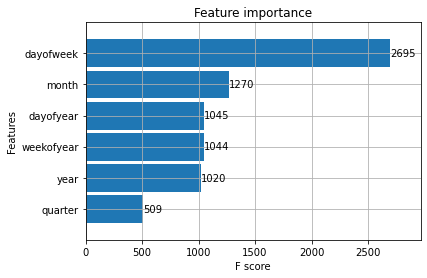

In [246]:
plot_importance(XGB_019, height=0.9)

In [235]:
XGB_005 = XGBRegressor(n_estimators=500)
XGB_005.fit(X_Train_005,Y_Train_005,eval_metric="mae")
Forecast_XGB_005=XGB_005.predict(X_Test_005)
print(Forecast_XGB_005)

[2007.5735 1942.4476 2077.079  2043.9902 2023.8004 2450.246  2415.904
 2367.708  2122.0645 2022.7267 2053.3845 1982.2429 1932.8173 2033.2356
 2052.0884 1980.3429 2079.6724 2500.6064]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

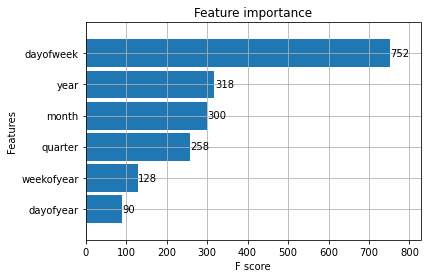

In [247]:
plot_importance(XGB_005, height=0.9)

In [236]:
XGB_001 = XGBRegressor(n_estimators=500)
XGB_001.fit(X_Train_001,Y_Train_001,eval_metric="mae")
Forecast_XGB_001=XGB_001.predict(X_Test_001)
print(Forecast_XGB_001)

[18.927235 16.556381 18.962944 18.853317 17.920477 19.63055  18.477133
 18.95945  17.846174 17.229235 17.450508 18.950768 18.333149 18.32012
 18.8057   16.943996 19.113632 19.073214 18.969059 18.887802 17.874027]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

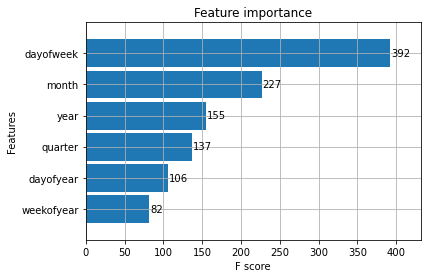

In [248]:
plot_importance(XGB_001, height=0.9)

In [249]:
MAE_XGB_019=mean_absolute_error(Forecast_XGB_019,Y_Test_019)
MAE_XGB_005=mean_absolute_error(Forecast_XGB_005,Y_Test_005)
MAE_XGB_001=mean_absolute_error(Forecast_XGB_001,Y_Test_001)
print("MAE XGBoost Model Category 019: ",MAE_XGB_019)
print("MAE XGBoost Model Category 005: ",MAE_XGB_005)
print("MAE XGBoost Model Category 001: ",MAE_XGB_001)

MAE XGBoost Model Category 019:  633.9247722517326
MAE XGBoost Model Category 005:  266.29841274404083
MAE XGBoost Model Category 001:  2.2267223921128503


Model Ensemble

The method for combining both models into a single model ensemble is averaging the predictions of both models.

In [255]:
ensemble_prediction_019=(Forecast_XGB_019+Forecast_Arima_019)/2
ensemble_prediction_005=(Forecast_XGB_005+Forecast_Arima_005)/2
ensemble_prediction_001=(Forecast_XGB_001+Forecast_Arima_001)/2

Error metrics for model ensemble

In [259]:
MAE_Ensemble_019=mean_absolute_error(ensemble_prediction_019,Y_Test_019)
MAE_Ensemble_005=mean_absolute_error(ensemble_prediction_005,Y_Test_005)
MAE_Ensemble_001=mean_absolute_error(ensemble_prediction_001,Y_Test_001)
print("MAE Model Ensemble Category 019: ",MAE_Ensemble_019)
print("MAE Model Ensemble Category 005: ",MAE_Ensemble_005)
print("MAE Model Ensemble Category 001: ",MAE_Ensemble_001)

MAE Model Ensemble Category 019:  561.6406747496818
MAE Model Ensemble Category 005:  238.79895122578375
MAE Model Ensemble Category 001:  2.1419957904003644


By combining the models better performance is achieved, with the exception of Category 001. This is because when ensembling models we run in the risk of worsen the performance by damaging the good predictions of a model with the errors of another model. 